In [119]:
import numpy as np
from matplotlib import pyplot as plt

file='/Users/localuser/Downloads/mergereanalysis_pop_stn_BMA.npz'
d=np.load(file)
rea_threshold=d['rea_threshold']
stn_lle=d['stn_lle']
pop_reamerge=d['pop_reamerge']
rea_csi=d['rea_csi']
mae_pop=d['mae_pop']

Text(0.5, 1.0, 'Mean CSI for ERA5 in 12 months')

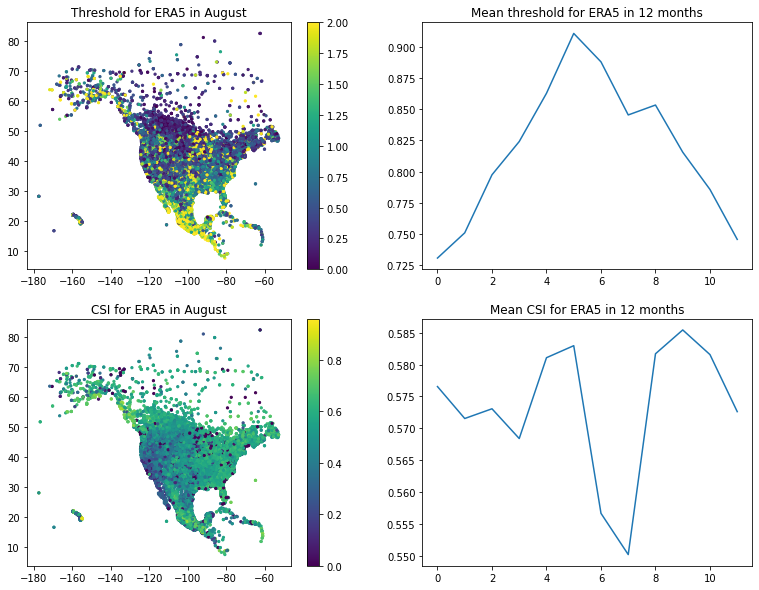

In [114]:
plt.figure(figsize=[13,10])
plt.subplot(221)
plt.scatter(stn_lle[:,1],stn_lle[:,0],5,rea_threshold[7,:,0])
plt.colorbar()
plt.title('Threshold for ERA5 in August')

plt.subplot(222)
plt.plot(np.nanmean(rea_threshold[:,:,0],axis=1))
plt.title('Mean threshold for ERA5 in 12 months')

plt.subplot(223)
plt.scatter(stn_lle[:,1],stn_lle[:,0],5,rea_csi[7,:,0])
plt.colorbar()
plt.title('CSI for ERA5 in August')

plt.subplot(224)
plt.plot(np.nanmean(rea_csi[:,:,0],axis=1))
plt.title('Mean CSI for ERA5 in 12 months')


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


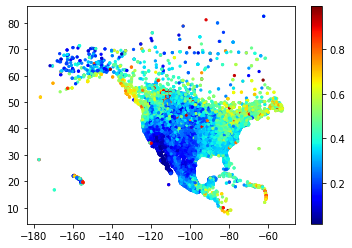

In [117]:
plt.scatter(stn_lle[:,1],stn_lle[:,0],5,np.nanmean(pop_reamerge,axis=1),cmap='jet')
plt.colorbar()

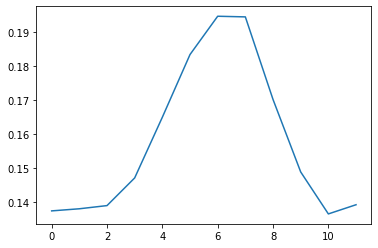

In [106]:
plt.plot(np.nanmean(mae_pop,axis=0))
plt.t

In [120]:
file='/Users/localuser/Downloads/daily_regression_stn_pop.npz'
d=np.load(file)
pop_regression=d['pop_regression']
stn_lle=d['stn_lle']
mae_pop_stn=d['mae_pop']

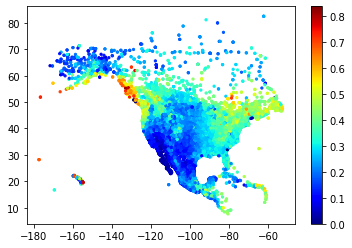

In [88]:
plt.scatter(stn_lle[:,1],stn_lle[:,0],5,np.nanmean(pop_regression,axis=1),cmap='jet')
plt.colorbar()

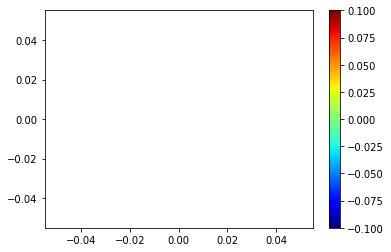

In [71]:
plt.scatter(stn_lle[:,1],stn_lle[:,0],5,z,cmap='jet')
plt.colorbar()

In [83]:
z=np.nanmean(pop_regression,axis=1)

In [79]:
file='/Users/localuser/GMET/merge/output_19800101-19800131.npz'
d=np.load(file)
pop=d['mae_pop']

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


Text(0.5, 1.0, 'Weight for reanalysis in August')

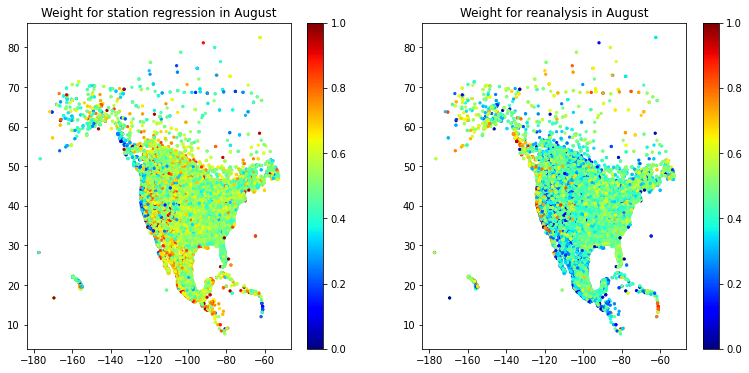

In [126]:
wstn=1/mae_pop_stn**2
wrea=1/mae_pop**2
ss=wstn+wrea
wstn=wstn/ss
wrea=wrea/ss
plt.figure(figsize=[13,6])

plt.subplot(121)
plt.scatter(stn_lle[:,1],stn_lle[:,0],5,wstn[:,7],cmap='jet')
plt.colorbar()
plt.clim([0,1])
plt.title('Weight for station regression in August')
plt.subplot(122)
plt.scatter(stn_lle[:,1],stn_lle[:,0],5,wrea[:,7],cmap='jet')
plt.colorbar()
plt.clim([0,1])
plt.title('Weight for reanalysis in August')